## Float vertical velocities from ITOP typhoon Fanapi (2010)

In [1]:
# interactive figure
%matplotlib widget

# auto reload modules
%load_ext autoreload
%autoreload 2

import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.colors as mcl
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import xarray as xr
import gsw
import sca_osbl_tool as sot
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
from numpy.polynomial import Polynomial as Poly
from matplotlib.legend_handler import HandlerLine2D
from sys import platform
from scipy import signal, stats
from constants import kappa, nan, pi, rho0, g, rhoa

%run ./Tools/load_font_cmap.py
plt.style.use('./Tools/paper.mplstyle') # load figure style

#### Float data preprocessing

In [3]:
# %run prep_fanapi_env.py
# %run prep_fanapi_gridded.py
# %run prep_fanapi_fluxes.py
# %run prep_fanapi_drift.py
%run prep_fanapi_wave.py

Binned float drift and wave data: Fanapi_dftb_wave_60_APL.nc saved at /media/zhihua/internal1/GDrive/UW/Research/Data/Hurricanes/ITOP/NBF/.
Binned float drift and wave data: Fanapi_dftb_wave_61_APL.nc saved at /media/zhihua/internal1/GDrive/UW/Research/Data/Hurricanes/ITOP/NBF/.
Binned float drift and wave data: Fanapi_dftb_wave_62_APL.nc saved at /media/zhihua/internal1/GDrive/UW/Research/Data/Hurricanes/ITOP/NBF/.
Binned float drift and wave data: Fanapi_dftb_wave_64_APL.nc saved at /media/zhihua/internal1/GDrive/UW/Research/Data/Hurricanes/ITOP/NBF/.


In [2]:
if platform == 'linux':
    data_root = '/media/zhihua/internal1/GDrive/'
elif platform == 'darwin':
    data_root = '/Users/zhihua/Documents/Work/Research/Projects/PhD-projects/Data/'

hurricane_root = data_root + '/Hurricanes/ITOP/'
hurricane_nbf_dir = hurricane_root + 'NBF/'
hurricane_met_dir = hurricane_root + 'Met/'
hurricane_wave_dir = hurricane_root + 'Wave/'
outfig_dir = '/Users/zhihua/Documents/Work/Research/Projects/PhD-projects/OSBL_w_scaling/Figures/'

In [ ]:
dws = xr.open_dataset(hurricane_wave_dir+'ww3_2010_src.nc').load() \
        .rename({'time': 'dws_time', 'longitude': 'lon', 'latitude': 'lat', 'frequency': 'freq', 'direction': 'dirc'})
dws.close()
dws = dws.where(dws.lon.isin(np.around(fan60.lon,3)), drop=True)
dws = dws.sel(dws_time=fan60.time.data, method='nearest')
dws = dws.sel(dws_time=xr.DataArray(dws.dws_time.data, dims='time'), 
              station=xr.DataArray(dws.station.data, dims='time')) \
         .drop_vars(['string16', 'station']).rename_vars({'dws_time': 'time'})

In [12]:
drad = dws.dirc/180*pi # to, clockwise relative to the North
bw_drad = np.abs(drad[1] - drad[0])
us_d2f = (np.sin(drad)*dws.efth*bw_drad).sum('dirc', skipna=False).set_index(time='time')
vs_d2f = (np.cos(drad)*dws.efth*bw_drad).sum('dirc', skipna=False).set_index(time='time')
d2f = np.sqrt(us_d2f**2 + vs_d2f**2)

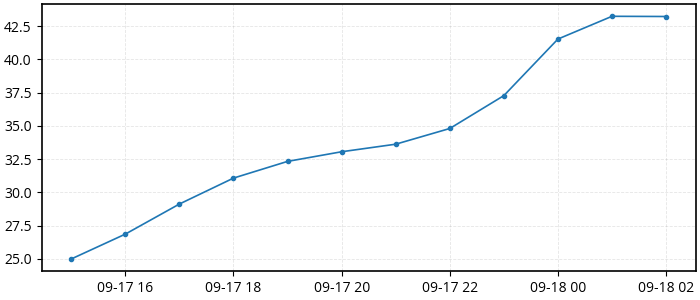

In [77]:
plt.close()
plt.figure(figsize=(7,3), constrained_layout=True)

# plt.plot(d2f.freq, np.arctan2(vs_d2f,us_d2f).T/pi*180%360);
# plt.xscale('log')
# plt.yscale('log');

# plt.plot(fan62.time, (90-fan62.theta_tau/pi*180)%360)
# plt.plot(dws.time, (dws.wnddir+180)%360);
plt.plot(fan60.time, flx60.U10.interp(time=fan60.time), '.-');

/home/zhihua/miniconda3/envs/scaOSBL/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


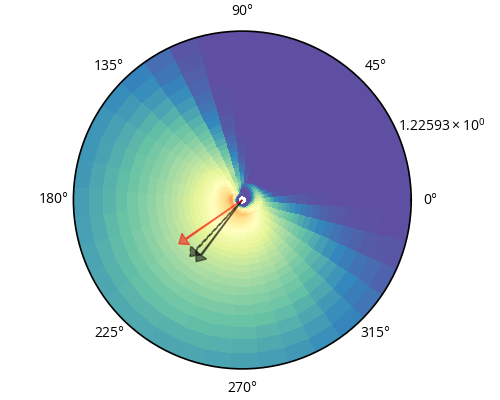

In [83]:
plt.close()
fig = plt.figure(figsize=(5,4), constrained_layout=True)
ax = fig.add_subplot(projection='polar')

j=9
# dtheta = -10
# theta = dws.direction.data.copy()
# theta[theta>89] = theta[theta>89] - 360
# wrp_theta = np.concatenate((theta, theta[-1:] + dtheta))
# wrp_E = np.concatenate((dws.efth.isel(time=j,station=6), dws.efth.isel(time=j,station=6)[:,0:1]), axis=1)
# ax.contourf((90-wrp_theta)/180*pi, dws.frequency, np.log10(wrp_E+1e-5), 30, vmin=-3, vmax=3, cmap='Spectral_r');
# ax.set_rmax(1)
# ax.set_rscale('symlog');

tt, rr = np.meshgrid(dws.dirc, dws.freq)
tt[tt>89] = tt[tt>89] - 360
ax.pcolormesh((90-tt)/180*pi, rr, np.log10(dws.efth.isel(time=j)+1e-5), 
              vmin=-5, vmax=5, cmap='Spectral_r', shading='auto');
ax.set_rscale('symlog');
# wndt = (90-dws.wnddir.isel(time=j)-180)/180*pi
plt.arrow(fw60.theta_tau.isel(time=j), 0, 0, 0.5, alpha=0.5, 
          width=0.02, head_width=0.2, head_length=0.06, edgecolor='k', facecolor='k', lw=1);
plt.arrow(fw60.theta_tau.isel(time=j)-6/180*pi, 0, 0, 0.5, alpha=0.5, 
          width=0.02, head_width=0.2, head_length=0.06, edgecolor='k', facecolor='k', lw=1, ls='--');

wavet = (fw60.theta_ww+fw60.theta_tau).isel(time=j)
plt.arrow(wavet, 0, 0, 0.5, alpha=0.5, width=0.02, head_width=0.2, head_length=0.06, edgecolor='r', facecolor='r', lw=1);
# ax.set_rmax(0.8)


#### Load float data

In [3]:
env60 = xr.open_dataset(hurricane_nbf_dir+'Fanapi_env_60.nc').load()
env60.close()
env61 = xr.open_dataset(hurricane_nbf_dir+'Fanapi_env_61.nc').load()
env61.close()
env62 = xr.open_dataset(hurricane_nbf_dir+'Fanapi_env_62.nc').load()
env62.close()
env64 = xr.open_dataset(hurricane_nbf_dir+'Fanapi_env_64.nc').load()
env64.close()

tau_opt = 'APL'
flx60 = xr.open_dataset(hurricane_met_dir+f'Fanapi_fluxes_60_{tau_opt}.nc').load()
flx60.close()
flx60f = flx60.where(flx60.ihfront, drop=True)
flx61 = xr.open_dataset(hurricane_met_dir+f'Fanapi_fluxes_61_{tau_opt}.nc').load()
flx61.close()
flx61f = flx61.where(flx61.ihfront, drop=True)
flx62 = xr.open_dataset(hurricane_met_dir+f'Fanapi_fluxes_62_{tau_opt}.nc').load()
flx62.close()
flx62f = flx62.where(flx62.ihfront, drop=True)
flx64 = xr.open_dataset(hurricane_met_dir+f'Fanapi_fluxes_64_{tau_opt}.nc').load()
flx64.close()
flx64f = flx64.where(flx64.ihfront, drop=True)

dft60 = xr.open_dataset(hurricane_nbf_dir+f'Fanapi_drifts_60_{tau_opt}.nc').load().sel(time=slice(flx60f.time[0],None))
dft60.close()
dft61 = xr.open_dataset(hurricane_nbf_dir+f'Fanapi_drifts_61_{tau_opt}.nc').load().sel(time=slice(flx61f.time[0],None))
dft61.close()
dft62 = xr.open_dataset(hurricane_nbf_dir+f'Fanapi_drifts_62_{tau_opt}.nc').load().sel(time=slice(flx62f.time[0],None))
dft62.close()
dft64 = xr.open_dataset(hurricane_nbf_dir+f'Fanapi_drifts_64_{tau_opt}.nc').load().sel(time=slice(flx64f.time[0],None))
dft64.close()

fan60 = xr.open_dataset(hurricane_nbf_dir+f'Fanapi_drifts_binned_60_{tau_opt}.nc').load()
fan60.close()
fan61 = xr.open_dataset(hurricane_nbf_dir+f'Fanapi_drifts_binned_61_{tau_opt}.nc').load()
fan61.close()
fan62 = xr.open_dataset(hurricane_nbf_dir+f'Fanapi_drifts_binned_62_{tau_opt}.nc').load()
fan62.close()
fan64 = xr.open_dataset(hurricane_nbf_dir+f'Fanapi_drifts_binned_64_{tau_opt}.nc').load()
fan64.close()

fw60 = xr.open_dataset(hurricane_nbf_dir+f'Fanapi_dftb_wave_60_{tau_opt}.nc').load()
fw60.close()
fw61 = xr.open_dataset(hurricane_nbf_dir+f'Fanapi_dftb_wave_61_{tau_opt}.nc').load()
fw61.close()
fw62 = xr.open_dataset(hurricane_nbf_dir+f'Fanapi_dftb_wave_62_{tau_opt}.nc').load()
fw62.close()
fw64 = xr.open_dataset(hurricane_nbf_dir+f'Fanapi_dftb_wave_64_{tau_opt}.nc').load()
fw64.close()

### Save float GPS tracks for retrieving surface wave spectra

In [4]:
np.savetxt(hurricane_nbf_dir+'nbf60_hourly.track', 
           np.stack([fan60.time.dt.strftime('%Y-%m-%d %H:%M:%S'), fan60.lon, fan60.lat]).T,
           fmt=['%s','%.3f','%.3f'], delimiter='   ')
np.savetxt(hurricane_nbf_dir+'nbf61_hourly.track', 
           np.stack([fan61.time.dt.strftime('%Y-%m-%d %H:%M:%S'), fan61.lon, fan61.lat]).T,
           fmt=['%s','%.3f','%.3f'], delimiter='   ')
np.savetxt(hurricane_nbf_dir+'nbf62_hourly.track', 
           np.stack([fan62.time.dt.strftime('%Y-%m-%d %H:%M:%S'), fan62.lon, fan62.lat]).T,
           fmt=['%s','%.3f','%.3f'], delimiter='   ')
np.savetxt(hurricane_nbf_dir+'nbf64_hourly.track', 
           np.stack([fan64.time.dt.strftime('%Y-%m-%d %H:%M:%S'), fan64.lon, fan64.lat]).T,
           fmt=['%s','%.3f','%.3f'], delimiter='   ')

### Float trajectory, forcing and profiles

In [5]:
km = g/flx64.ustar**2*np.exp((pi/2-2.835)/0.48)
fm = np.sqrt(g*km)/2/pi
fm

<xarray.DataArray 'ustar' (time: 79)>
array([19.2476503 , 19.20022112, 19.15382281, 19.11482636, 19.07614248,
       19.04101367, 19.00782962, 18.91858008, 18.64471836, 18.3956196 ,
       18.19195109, 17.99258193, 17.78566469, 17.55935837, 17.3364386 ,
       17.11615357, 16.88716181, 16.66745918, 16.45564533, 16.24293468,
       16.04327789, 15.84051868, 15.64247365, 15.44425197, 15.24188355,
       15.02735189, 14.8181082 , 14.58246709, 14.33111556, 14.25501205,
       14.18482905, 14.09561304, 13.9929724 , 13.87500666, 13.75193855,
       13.63755896, 13.53543813, 13.44987427, 13.38727187, 13.34066606,
       13.28362702, 13.16039099, 12.94677579, 12.66482964, 12.35967221,
       12.09363256, 11.80915845, 11.46359229, 10.95400943, 10.38777364,
        9.94968101,  9.64299624,  9.41006718,  9.189731  ,  8.98696974,
        8.82557944,  9.68291943,  9.64040875,  9.60669236,  9.5773091 ,
        9.55601062,  9.53754599,  9.47843111,  9.36683458,  9.198048  ,
        8.83144169,  8.28886131,  7.71482345,  7.22503692,  6.83226994,
        6.85896446,  7.05269768,  7.0282108 ,  7.10044678,         nan,
               nan,         nan,         nan,         nan])
Coordinates:
    lon      (time) float64 126.3 126.3 126.3 126.3 ... 125.9 125.9 125.9 125.9
    lat      (time) float64 23.47 23.47 23.47 23.46 ... 23.28 23.28 23.28 23.28
  * time     (time) datetime64[ns] 2010-09-17T01:08:37.589193 ... 2010-09-18T...
    yd       (time) float64 260.0 260.1 260.1 260.1 ... 261.1 261.1 261.1 261.1

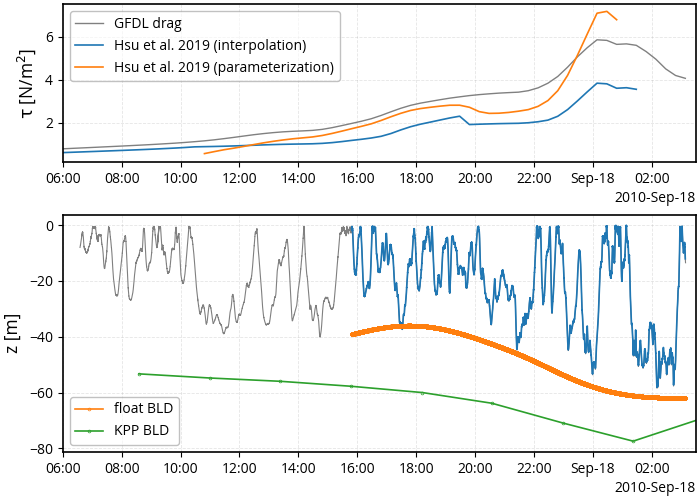

In [4]:
plt.close()
fig = plt.figure(figsize=(7,5), constrained_layout=True)
spec = fig.add_gridspec(10,1)

ax0 = fig.add_subplot(spec[:4, :])

ax0.plot(flx64.time, flx64.taum_GFDL, 'gray', lw=1)
ax0.plot(flx64.time, flx64.taum)
ax0.plot(flx64.time, flx64.taum_ewd)
# plt.gca().set_prop_cycle(None)
# ax0.plot(flx64_uri.time, flx64_uri.taum, '--')
ax0.legend(['GFDL drag', 'Hsu et al. 2019 (interpolation)', 'Hsu et al. 2019 (parameterization)',
            'Zhou et al. 2022 (interpolation)'], fontsize=10)
ax0.set_ylabel(r'$\tau$ [N/m$^2$]')

ax1 = fig.add_subplot(spec[4:, :], sharex=ax0)
sim = sio.loadmat(hurricane_wave_dir+'UV_Stokes_'+str(64)+'.mat', squeeze_me=True, struct_as_record=False)
ax1.plot(env64.timeP.sel(timeP=slice('2010-09-17 06:35:00','2010-09-18 03:09:00')),
        -env64.Pc.sel(timeP=slice('2010-09-17 06:35:00','2010-09-18 03:09:00')), 'gray', lw=0.8, label='_nolegend_')
ax1.plot(dft64.time, dft64.z, label='_nolegend_')
ax1.plot(dft64.time, -dft64.bld, '-o', ms=2, mfc='none', mew=0.5)
ax1.plot(sot.mtime2pytime(sim['timef']), -sim['KPP_OBL_float'], '-o', ms=2, mfc='none', mew=0.5)
ax1.legend(['float BLD', 'KPP BLD'], fontsize=10)
ax1.set_ylabel('z [m]')
ax1.set_xlim('2010-09-17 06:00:00','2010-09-18 03:30:00');
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()));

# plt.savefig(outfig_dir + 'Fanapi_drift_64.png');

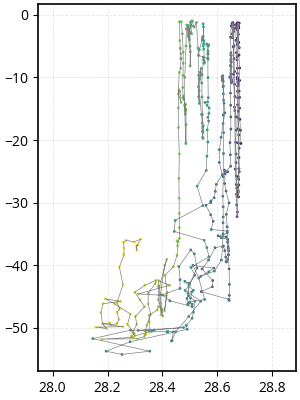

In [6]:
plt.close()
fig = plt.figure(figsize=(3,4), constrained_layout=True)

time_range = slice('2010-09-17 22:00:00','2010-09-18 02:00:00')
plt.plot(env64.T.sel(time=time_range), -env64.P.sel(time=time_range), c='gray', lw=0.5);
plt.scatter(env64.T.sel(time=time_range), -env64.P.sel(time=time_range), 1, env64.yd.sel(time=time_range))
plt.xlim(env64.T.sel(time=time_range).min()-0.2, env64.T.sel(time=time_range).max()+0.2);

In [7]:
era5 = xr.open_dataset(hurricane_root+'Reanalysis/ERA5/fanapi_surface_hourly_Sep2010.nc').load()
era5.close()
# reanalysis mean is over the past hour
era5 = era5.assign_coords({'time': ('time', era5.time.values - pd.Timedelta(minutes=30))})
era5 = era5.rename({'longitude': 'lon', 'latitude': 'lat'})
era5['U10'] = np.sqrt(era5.u10**2 + era5.v10**2)

Hsu19 = sio.loadmat(hurricane_met_dir+'Fanapi_wind_lon_lat.mat', squeeze_me=True, struct_as_record=False)
pytime = sot.mtime2pytime(Hsu19['Jday_gmt'])
Fanapi = xr.Dataset(data_vars=dict(u10=(('lat','lon','time'), Hsu19['u10']), 
                                   v10=(('lat','lon','time'), Hsu19['v10']),
                                   uhx=(('time'), Hsu19['uhx']),
                                   uhy=(('time'), Hsu19['uhy']),
                                   trk_lat=(('time'), Hsu19['trk_lat']),
                                   trk_lon=(('time'), Hsu19['trk_lon'])),
                    coords=dict(lon=(('lon'), Hsu19['Lon']),
                                lat=(('lat'), Hsu19['Lat']),
                                time=(('time'), pytime)),
                    attrs=dict(description='Typhoon Fanapi surface wind and track from Hsu et al. 2019',
                               lon2km=Hsu19['lon2km'], lat2km=Hsu19['lat2km'], mrmw=20))
Fanapi['U10'] = np.sqrt(Fanapi.u10**2 + Fanapi.v10**2)
# Fanapi['yd'] = (('time'), sot.pytime2yd(Fanapi.time))

In [8]:
def get_rdt(U10):
    """
    Compute correction factor for air-sea temperature difference
    Based on Lin et al. 2011, Fig. S8
    """
    return np.minimum(1+0.4*np.tanh((U10-32)/5), 1-0.6*np.tanh((U10-32)/5))

def get_rdq(U10):
    """
    Compute correction factor for air-sea specific humidity difference
    Based on Lin et al. 2011, Fig. S8
    """
    return np.minimum(0.85+0.4*np.tanh((U10-32)/3), 0.85-0.45*np.tanh((U10-32)/5))

In [9]:
Fanapi['shf'] = era5.msshf.interp(lon=Fanapi.lon, lat=Fanapi.lat, time=Fanapi.time)
Fanapi['lhf'] = era5.mslhf.interp(lon=Fanapi.lon, lat=Fanapi.lat, time=Fanapi.time)
Fanapi['u10E'] = era5.u10.interp(lon=Fanapi.lon, lat=Fanapi.lat, time=Fanapi.time)
Fanapi['v10E'] = era5.v10.interp(lon=Fanapi.lon, lat=Fanapi.lat, time=Fanapi.time)
Fanapi['U10E'] = np.sqrt(Fanapi.u10E**2 + Fanapi.v10E**2)
Fanapi = Fanapi.transpose('lat', 'lon', 'time')

rwind = Fanapi.U10/Fanapi.U10E
rdt = get_rdt(Fanapi.U10)
rdq = get_rdq(Fanapi.U10)
# Fanapi['shf_c'] = Fanapi.shf*rwind*rdt
# Fanapi['lhf_c'] = Fanapi.lhf*rwind*rdq

In [10]:
U10bins = np.arange(14.5,57.5,1)
bshfE = sot.bin_stat_1d(Fanapi.U10E, -Fanapi.shf, U10bins, mask=Fanapi.U10E>=15, ns_min=40)
blhfE = sot.bin_stat_1d(Fanapi.U10E, -Fanapi.lhf, U10bins, mask=Fanapi.U10E>=15, ns_min=40)
bshf = sot.bin_stat_1d(Fanapi.U10, -Fanapi.shf, U10bins, mask=Fanapi.U10>=15, ns_min=40)
blhf = sot.bin_stat_1d(Fanapi.U10, -Fanapi.lhf, U10bins, mask=Fanapi.U10>=15, ns_min=40)
bshf1 = sot.bin_stat_1d(Fanapi.U10, -Fanapi.shf*rwind, U10bins, mask=Fanapi.U10>=15, ns_min=40)
blhf1 = sot.bin_stat_1d(Fanapi.U10, -Fanapi.lhf*rwind, U10bins, mask=Fanapi.U10>=15, ns_min=40)
bshf2 = sot.bin_stat_1d(Fanapi.U10, -Fanapi.shf*rwind*rdt, U10bins, mask=Fanapi.U10>=15, ns_min=40)
blhf2 = sot.bin_stat_1d(Fanapi.U10, -Fanapi.lhf*rwind*rdq, U10bins, mask=Fanapi.U10>=15, ns_min=40)

In [11]:
U10obs = np.array([35, 55, 100])*0.51444 # [m/s]
shfobs = np.array([22.24, 49.99, 57.96]) # [W/m^2]
shfobs_std = np.array([12.19, 40.79, 35.26])
lhfobs = np.array([207.7, 303.89, 463.7])
lhfobs_std = np.array([26.67, 88.71, 143.77])

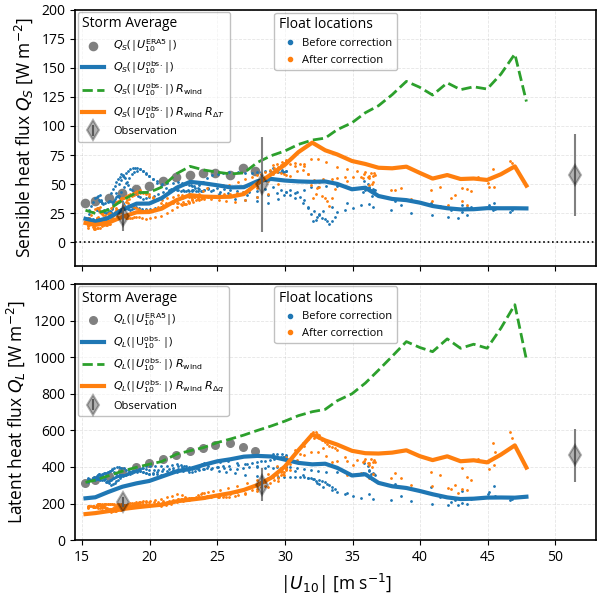

In [14]:
plt.close()
_,ax = plt.subplots(2,1, figsize=(6,6), constrained_layout=True, sharex=True)

shf_s, = ax[0].plot(flx60.U10, -flx60.shfE, '.', ms=2, c='C0')
ax[0].plot(flx61.U10, -flx61.shfE, '.', ms=2, c='C0')
ax[0].plot(flx62.U10, -flx62.shfE, '.', ms=2, c='C0')
ax[0].plot(flx64.U10, -flx64.shfE, '.', ms=2, c='C0');
shf2_s, = ax[0].plot(flx60.U10, -flx60.shf,  '.', ms=2, c='C1');
ax[0].plot(flx61.U10, -flx61.shf,  '.', ms=2, c='C1');
ax[0].plot(flx62.U10, -flx62.shf,  '.', ms=2, c='C1');
ax[0].plot(flx64.U10, -flx64.shf,  '.', ms=2, c='C1');
shfE_h = ax[0].scatter(bshfE.x.m, bshfE.y.s, 35, c='gray')
shf_h, = ax[0].plot(bshf.x.m, bshf.y.s, c='C0', lw=3)
shf1_h, = ax[0].plot(bshf1.x.m, bshf1.y.s, c='C2', lw=2, ls='--')
shf2_h, = ax[0].plot(bshf2.x.m, bshf2.y.s, c='C1', lw=3)
shfobs_h = ax[0].errorbar(U10obs, shfobs, yerr=shfobs_std,
                          ls='none', mfc=mcl.to_rgba('k',0.3), c='k', marker='d',
                          ms=10, elinewidth=1.5, mew=1.5, ecolor='gray', lw=1.5);
ax[0].axhline(0, ls=':', c='k')
lgd0 = ax[0].legend([shfE_h, shf_h, shf1_h, shf2_h, shfobs_h], 
             [r'$Q_S$(|$U_{10}^{\mathrm{ERA5}}$|)', r'$Q_S$(|$U_{10}^{\mathrm{obs.}}$|)', 
              r'$Q_S$(|$U_{10}^{\mathrm{obs.}}$|) $R_{\mathrm{wind}}$', 
              r'$Q_S$(|$U_{10}^{\mathrm{obs.}}$|) $R_{\mathrm{wind}}$ $R_{\Delta T}$', 'Observation'], 
            fontsize=8, borderaxespad=0.2, title='Storm Average', title_fontsize='small')
ax[0].add_artist(lgd0)
lgd0._legend_box.align = 'left'
lgd0f = ax[0].legend([shf_s, shf2_s], ['Before correction', 'After correction'], 
                     fontsize=8, borderaxespad=0.3, title='Float locations', title_fontsize='small', 
                     loc='upper center', markerscale=3, handletextpad=0.1)
lgd0f._legend_box.align = 'left'
ax[0].set_ylabel(r'Sensible heat flux $Q_S$ [W m$^{-2}$]');
ax[0].set_ylim(-20, 200)

lhf_s, = ax[1].plot(flx60.U10, -flx60.lhfE, '.', ms=2, c='C0');
ax[1].plot(flx61.U10, -flx61.lhfE, '.', ms=2, c='C0');
ax[1].plot(flx62.U10, -flx62.lhfE, '.', ms=2, c='C0');
ax[1].plot(flx64.U10, -flx64.lhfE, '.', ms=2, c='C0');
lhf2_s, = ax[1].plot(flx60.U10, -flx60.lhf,  '.', ms=2, c='C1');
ax[1].plot(flx61.U10, -flx61.lhf,  '.', ms=2, c='C1');
ax[1].plot(flx62.U10, -flx62.lhf,  '.', ms=2, c='C1');
ax[1].plot(flx64.U10, -flx64.lhf,  '.', ms=2, c='C1');
lhfE_h = ax[1].scatter(blhfE.x.m, blhfE.y.s, 30, c='gray')
lhf_h, = ax[1].plot(blhf.x.m, blhf.y.s, c='C0', lw=3)
lhf1_h, = ax[1].plot(blhf1.x.m, blhf1.y.s, c='C2', lw=2, ls='--')
lhf2_h, = ax[1].plot(blhf2.x.m, blhf2.y.s, c='C1', lw=3)
lhfobs_h = ax[1].errorbar(U10obs, lhfobs, yerr=lhfobs_std,
                          ls='none', mfc=mcl.to_rgba('k',0.3), c='k', marker='d',
                          ms=10, elinewidth=1.5, mew=1.5, ecolor='gray', lw=1.5);
lgd1 = ax[1].legend([lhfE_h, lhf_h, lhf1_h, lhf2_h, lhfobs_h], 
             [r'$Q_L$(|$U_{10}^{\mathrm{ERA5}}$|)', r'$Q_L$(|U$_{10}^{\mathrm{obs.}}$|)', 
              r'$Q_L$(|$U_{10}^{\mathrm{obs.}}$|) $R_{\mathrm{wind}}$', 
              r'$Q_L$(|$U_{10}^{\mathrm{obs.}}$|) $R_{\mathrm{wind}}$ $R_{\Delta q}$', 'Observation'], 
            fontsize=8, borderaxespad=0.2, title='Storm Average', title_fontsize='small')
ax[1].add_artist(lgd1)
lgd1._legend_box.align = 'left'
lgd1f = ax[1].legend([lhf_s, lhf2_s], ['Before correction', 'After correction'], 
                     fontsize=8, borderaxespad=0.2, title='Float locations', title_fontsize='small', 
                     loc='upper center', markerscale=3, handletextpad=0.1)
lgd1f._legend_box.align = 'left'
ax[1].set_ylabel(r'Latent heat flux $Q_L$ [W m$^{-2}$]')
ax[1].set_xlabel(r'|$U_{10}$| [m s$^{-1}$]')
ax[1].set_ylim(0, 1400);
ax[1].set_xlim(14.5, 53);

plt .savefig(outfig_dir + 'Fanapi_turbheatfluxes_correction.png', dpi=600);

In [8]:
def w_from_drift(z, yd, floatID, Lfloat, dt=30, dftn=None):
    """
    Compute vertical velocity from pressure change during a drift
    """
    dts = yd*24*60*(60/dt) # in unit of dt
    # even spacing time array
    yd_even = np.arange(np.ceil(dts[0]), np.floor(dts[-1])+1)/(60/dt)/60/24
    df = pd.DataFrame(np.column_stack((yd, z)), columns=['yd', 'z']).set_index('yd')
    df = df.loc[~df.index.duplicated(), :] # remove duplicated time points
    # igap = np.where(np.diff(df.index)*24*3600 > 10)[0][0] + 1 # first gap longer than 10s
    # df = df.iloc[:igap,:]
    dfi = df.reindex(df.index.union(yd_even)) \
            .interpolate(method='pchip', limit_direction='both', limit_area='inside').reindex(yd_even)
    
    # trimmed = trim_traj(dfi.z)
    # dfi = dfi.iloc[trimmed]
    dfi['w'] = np.convolve(dfi.z, [1, 0, -1], 'same')/(2*dt)
    dfi = dfi.iloc[1:-1,:] # invalid results at both ends, right exclusive
    if dt==1:
        # filter w
        wmedf = dfi.w.rolling(5, center=True).median() # edges are NaN
        dfi['wf'] = sot.butter_lpfilt(wmedf, 0.1/2/pi, 1)
        dfi = dfi[dfi.wf.notnull()] # drop NaN at egdes
        
        dfi['wf2'] = dfi.wf**2
        dfi['wf3'] = dfi.wf**3
        wrms2 = dfi.wf2.mean()
        dfi['wf2bulk'] = wrms2
        
        # layer-averaged dissipation rate from Lagrangian spectrum
        omega,Pww = sot.get_psd(dfi.wf, fs=1/dt)
        Paa = omega**2*Pww
        Pnoise = 0.001 # better moise model?
        site = 'Fanapi'+str(floatID)
        epsb, omega0, omegaM = sot.fit_spec(omega, Paa, Pnoise, Lfloat, show_fig=False, site=site, dftn=dftn)
        omegaL = (epsb/(Lfloat**2))**(1/3)
        nu = 1.19e-6 # kinematic viscosity [m^2/s], from The Engineering Toolbox [T=15, S=35]
        omega_Komogrov = 2*pi/np.sqrt(nu/epsb)
        omega_i = np.logspace(-4, np.around(np.log10(omega_Komogrov),1), 100)
        PaaM_i = sot.modelaccspL(epsb, omega0, omega_i, Lfloat=Lfloat)
        PaaM0_i = sot.modelaccspL(epsb, omega0, omega_i, Lfloat=1e-10)
        delw2 = np.trapz(PaaM0_i*omega_i**(-2),omega_i) - np.trapz(PaaM_i*omega_i**(-2),omega_i)
        omega_c = np.logspace(-4, 0, 80)
        PaaM_c = sot.modelaccspL(epsb, omega0, omega_c, Lfloat=Lfloat)
        Paa_c = np.interp(omega_c, omega, Paa, left=nan, right=nan)
        Paa_c[omega_c >= omegaM] = nan
        dfi['epsbulk'] = epsb
        dfi['delw2'] = delw2
        speci = pd.DataFrame(data=dict(raw=Paa_c, fit=PaaM_c, eps=epsb, omega0=omega0, omegaL=omegaL, myd=df.index.values.mean(),
                                       wrms2=wrms2, delw2=delw2, omega=omega_c)).set_index('omega')
    # max dt in fast pressure drift data is ~ 3s, it's ok to interpolate evenly spaced time vector 
    # skip the re-interpolation back to original sampling time
    return dfi, speci


def bin_w(df, year):
    """
    Bin average vertical velocities in unifom time and z grid
    """
    # set bin edges
    time_start, time_end = df.time.iloc[[0, -1]].round('60min')
    hhtime = pd.Timedelta(minutes=30)
    time_bins = pd.date_range(time_start-hhtime, time_end+hhtime, freq='H')
    zbt = np.floor(df.z.min())
    z_bins = np.arange(zbt, 1)
    
    # bin data
    grpd = df.groupby([pd.cut(df.time, time_bins), pd.cut(df.z, z_bins)])
    grpm = grpd.mean()
    grpc = grpd.w.count().replace(0, nan).rename('n')
    bnd = pd.concat([grpm, grpc], axis=1).rename(columns={'z': 'mz', 'yd': 'myd'}).reset_index()
    bnd.time = bnd.time.apply(lambda x: x.mid)
    bnd.z = bnd.z.apply(lambda x: x.mid)
    
    # to xarray dataset
    bnd_ds = bnd.set_index(['time', 'z']).to_xarray()
    bnd_ds['myd'] = bnd_ds.myd.mean(dim='z')
    bnd_ds['bld'] = bnd_ds.bld.mean(dim='z')
    bnd_ds['drift'] = bnd_ds.drift.mean(dim='z')
    bnd_ds['epsbulk'] = bnd_ds.epsbulk.mean(dim='z')
    bnd_ds['wf2bulk'] = bnd_ds.wf2bulk.mean(dim='z')
    bnd_ds = bnd_ds.dropna('time', how='all') # remove empty time intervals between drifts
    return bnd_ds


In [ ]:
site_root = data_root + 'Hurricanes/ITOP/'
met_dir = site_root + 'Met/'
nbf_dir = site_root + 'NBF/'
floatID = 61
env_name = 'Fanapi_env_'+str(floatID)+'.nc'
year = 2010
Lfloat = 0.92/2

F = xr.open_dataset(met_dir+'Fanapi_fluxes_'+str(floatID)+'.nc')

# original float data
with xr.open_dataset(nbf_dir+env_name) as E:
    drift0 = E.drift.values
    time_env = E.time.values
    yd = E.yd.values
    ydP = E.ydP.values
    Pc = E.Pc.values
    P = E.P.values
    B = E.B.values
    lat = E.lat.reset_coords('yd', drop=True)
    lon = E.lon.reset_coords('yd', drop=True)
mlat = np.mean(lat.values)
Zc = gsw.z_from_p(Pc, mlat)
    
# drift selection
_,Iclump = sot.get_clumps(drift0, min_len=360) # at least 3-hours long, 3*3600/30=360
# index for the beginning of drift: when the rate of change of float buoyancy is less than 0.02 cc/s
i_drift_on = [np.where( np.abs(np.gradient(B[I], yd[I]*24*3600)) < 0.02 )[0][0] for I in Iclump]
Idrift = [sot.re_slice(I,i) for I,i in zip(Iclump, i_drift_on)]

# i_turb_on = [first_turb(P[I]) for I in Idrift]
# Idrift = [sot.re_slice(I,i) for I,i in zip(Idrift, i_turb_on)]

skewP = np.around(np.array([stats.skew(P[I]) for I in Idrift]),1)
Idrift = [I for I,SK in zip(Idrift,skewP) if abs(SK) < 1]
Idrift = [I for I in Idrift if (I.stop-I.start)>=360]

# compute w
drift, dfs, specs = ([] for i in range(3))
# mpl.use('Agg') # change backend to avoid memory leak when doing batches of plotting
# mpl.pyplot.ioff()
for i in Idrift:
    dftn = int(np.unique(drift0[i])[0])
    drift.append(dftn)
    idf = ((ydP >= yd[i.start]) & (ydP <= yd[i.stop-1])) & (ydP <= F.yd.values[-1])
    if floatID == 61:
        yd0 = sot.pytime2yd(np.datetime64('2010-09-17 19:10:00'))
        idf = idf & (ydP >= yd0) # float 61 before yd0 drifted below mixed layer
    df, spec = w_from_drift(Zc[idf], ydP[idf], floatID, Lfloat, dt=1, dftn=dftn)
    # mixing layere depth
    df.insert(0, 'time', sot.yd2pytime(df.index, year))
    hmix = sot.get_hmix(df.index, -df.z, np.sqrt(F.taum_GFDL.interp(time=df.time)/rho0),
                        F.wbnet.interp(time=df.time), 1, DOF=20)
    df['bld'] = sot.butter_lpfilt(hmix, 1/3600/6, 1) # 12-hr lowpass
    # select high wind and times before storm arrives
    Fhf = F.where(F.ihfront, drop=True)
    df = df.loc[(df.time >= Fhf.time.values[0]) & (df.time <= Fhf.time.values[-1])]
    if np.unique(spec.omegaL/spec.omega0) <= 1: # don't use drift data when the spectral fit is bad
        continue
    if df.wf.isnull().sum() != df.w.isnull().sum():
        print('Filtered w has NaN')
        break
    dfs.append(df)
    specs.append(spec)
# mpl.pyplot.ion()
# mpl.use('module://ipympl.backend_nbagg')

specs = pd.concat(specs, keys=drift, names=['drift', 'omega']).to_xarray().transpose('omega', 'drift')
specs.attrs['Lfloat'] = Lfloat
varlist = ['eps', 'omega0', 'omegaL', 'myd', 'wrms2', 'delw2']
for var in varlist:
    specs.update({var: specs[var].mean('omega')})
dfs = pd.concat(dfs, keys=drift, names=['drift', 'yd']).reset_index()
dft = dfs.set_index('time').to_xarray()
dft['ustar'] = F.ustar.reset_coords('yd', drop=True).interp(time=dft.time)
dft['wbnet'] = F.wbnet.reset_coords('yd', drop=True).interp(time=dft.time)
dft['lat'] = lat.interp(time=dft.time)
dft['lon'] = lon.interp(time=dft.time)

#### Load forcing data

In [17]:
def get_ewd_Cdn(U10, theta, r, Uh):
    """
    Compute the effective wind duration based parameterization of drag coefficient according to Hsu et al. (2019)
    """
    fetch = get_fetch(theta, r)
    psi = get_psi(Uh, theta)
    ewd = g*(fetch*1e3/Uh)/(U10*np.cos(psi*pi/180))
    
    Cdnd = np.full_like(U10, nan)
    phi = np.full_like(U10, nan)
    
    idx1 = (ewd >= 5e3) & (ewd <= 9e3)
    idx2 = (ewd >= 9e3) & (ewd <= 22e3)
    Cdnd[idx1] = 2.7*1e-3
    Cdnd[idx2] = (-5.2e-3*(ewd[idx2]/1e3)**2 + 3.8e-3*ewd[idx2]/1e3 + 3.05)*1e-3
    
    idx3 = (ewd >= 5e3) & (ewd <= 12e3)
    idx4 = (ewd >= 12e3) & (ewd <= 22e3)
    phi[idx3] = 0
    phi[idx4] = 0.44*(ewd[idx4]/1e3)**2 - 9.7*ewd[idx4]/1e3 + 52.45
    
    Cdn = Cdnd*np.sqrt(1 + np.tan(phi/180*pi)**2)
    return Cdnd, phi, Cdn


def get_GFDL_Cdn(U10):
    """
    Compute the GFDL (HWRF) parameterization of drag coefficient according to Zhou et al. (2022)
    """
    a1 =  1.044183210405817e-12
    a2 = -5.707116220939218e-11
    a3 =  8.005722172810571e-10
    a4 =  6.322045801589353e-09
    a5 = -2.422002988137712e-07
    a6 =  2.269200594753249e-06
    a7 = -6.029592778169796e-06
    a8 =  8.882284703541603e-06
    a9 = -2.371341185499601e-06
    
    b1 =  1.814407011197660e-15
    b2 = -1.602907562918788e-13
    b3 = -3.351205313520358e-11
    b4 =  6.036179295940524e-09
    b5 = -3.725481686822030e-07
    b6 =  1.059761705898929e-05
    b7 = -1.375241830530252e-04
    b8 =  8.538858261732818e-04
    b9 = -1.936638976963742e-03
    
    idx1 = U10 <= 0.4
    idx2 = (U10 > 0.4) & (U10 <= 9.3)
    idx3 = (U10 > 9.3) & (U10 <  60)
    idx4 = U10 >= 60
    
    z0 = np.full_like(U10, nan)
    z0[idx1] = 4e-7
    z0[idx2] = a9 + a8*U10[idx2] + a7*U10[idx2]**2 + a6*U10[idx2]**3 + a5*U10[idx2]**4 + \
               a4*U10[idx2]**5 + a3*U10[idx2]**6 + a2*U10[idx2]**7 + a1*U10[idx2]**8
    z0[idx3] = b9 + b8*U10[idx3] + b7*U10[idx3]**2 + b6*U10[idx3]**3 + b5*U10[idx3]**4 + \
               b4*U10[idx3]**5 + b3*U10[idx3]**6 + b2*U10[idx3]**7 + b1*U10[idx3]**8
    z0[idx4] = 1.3025e-3
    return (kappa/np.log(10/z0))**2


def get_fetch(theta, r):
    """
    Compute the fetch under a tropical cyclone according to the parametric model of Hwang et al. (2016)
    """
    theta_grid = np.array([-13, 7, 22, 67, 115, 157, 200, 242, 270, 292, 330, 347, 367])
    A_grid = np.array([100, 94.72, 108.79, 77.47, -33.58, 37.75, 43.45, 134.73, 107.65, 149.25, 109.42, 100, 94.72])
    alpha_grid = np.array([0.5, 0.14, -0.01, 0.93, 1.78, 0.4, 0.7, 0.69, 0.46, 0.3, 0.81, 0.5, 0.14])
    
    A = np.interp(theta, theta_grid, A_grid, period=360)
    alpha = np.interp(theta, theta_grid, alpha_grid, period=360)
    return alpha*r + A

def get_psi(Uh, theta):
    """
    Compute the angle between wind and dominant waves under a tropical cyclone according to Moon et al. (2004)
    """
    Uh0 = 1
    psi = 30 + 3*(Uh/Uh0)*(1 + np.tanh(theta-10))
    return psi

def get_Fanapi_Cdn(U10, ifr, ifl, opt='APL'):
    """
    Compute the neutral downwind drag coefficient under typhoon Fanapi (2010),
    according to the results of Hsu et al. (2019) [drag_option='APL'], or Zhou et al. (2022) [drag_option='URI']
    The low wind regime (< 25 m/s) is supplemented by the results of Large and Pond (1981)
    Cdnd: neutral downwind drag coefficient
    phi: angle of stress, clockwise from wind [degree]
    """
    Cdnd = np.full_like(U10, nan)
    phi = np.full_like(U10, nan)
    
    U10_low = np.array([4, 11, 20])
    Cdnd_low = np.array([1.2, 1.2, 1.79])*1e-3
    phi_low = np.zeros_like(U10_low)
    
    # front_right
    if opt == 'APL':
        U10_high = np.array([25, 27.5, 35, 42.5, 60])
        Cdnd_high = np.array([1.13, 1.13, 2.37, 1.63, 1.63])*1e-3
        phi_high = np.array([42, 42, 2, 6, 6])
    elif opt == 'URI':
        U10_high = np.array([25, 26.92, 33.07, 42.27, 60])
        Cdnd_high = np.array([1.319, 1.319, 1.643, 1.781, 1.781])*1e-3
        phi_high = np.array([50.59, 50.59, -9.36, 0.63, 0.63])
    U10_grid = np.hstack((U10_low, U10_high))
    Cdnd_grid = np.hstack((Cdnd_low, Cdnd_high))
    phi_grid = np.hstack((phi_low, phi_high))
    Cdnd[ifr] = np.interp(U10[ifr], U10_grid, Cdnd_grid)
    phi[ifr] = np.interp(U10[ifr], U10_grid, phi_grid)
    
    # front_left
    if opt == 'APL':
        U10_high = np.array([25, 27.5, 35, 60])
        Cdnd_high = np.array([1.69, 1.69, 1.4, 1.4])*1e-3
        phi_high = np.array([-9, -9, -12, -12])
    elif opt == 'URI':
        U10_high = np.array([25, 27.06, 32.5, 60])
        Cdnd_high = np.array([2.254, 2.254, 1.245, 1.245])*1e-3
        phi_high = np.array([-12.19, -12.19, -13.06, -13.06])
    U10_grid = np.hstack((U10_low, U10_high))
    Cdnd_grid = np.hstack((Cdnd_low, Cdnd_high))
    phi_grid = np.hstack((phi_low, phi_high))
    Cdnd[ifl] = np.interp(U10[ifl], U10_grid, Cdnd_grid)
    phi[ifl] = np.interp(U10[ifl], U10_grid, phi_grid)
    
    Cdn = Cdnd*np.sqrt(1 + np.tan(phi/180*pi)**2)
    return Cdnd, phi, Cdn

In [18]:
def get_La(Lagcur, ustar, theta_tau, h='hmix'):
    """
    Compute Langmuir numbers
    """
    if h == 'hmix':
        bld = Lagcur.hmix
    elif h == 'hobl':
        bld = Lagcur.hobl_kpp
    
    us_SL = xr.apply_ufunc(get_SL_mean, Lagcur.us, Lagcur.z, Lagcur.delz, bld,
                           input_core_dims=[['z'], ['z'], ['z'], []], vectorize=True, output_dtypes=[float])
    vs_SL = xr.apply_ufunc(get_SL_mean, Lagcur.vs, Lagcur.z, Lagcur.delz, bld,
                           input_core_dims=[['z'], ['z'], ['z'], []], vectorize=True, output_dtypes=[float])
    us_ref = xr.apply_ufunc(np.interp, -bld, Lagcur.z, Lagcur.us,
                            input_core_dims=[[], ['z'], ['z']], vectorize=True, output_dtypes=[float])
    vs_ref = xr.apply_ufunc(np.interp, -bld, Lagcur.z, Lagcur.vs,
                            input_core_dims=[[], ['z'], ['z']], vectorize=True, output_dtypes=[float])
    us1 = Lagcur.us.sel(z=-1)
    vs1 = Lagcur.vs.sel(z=-1)
    duLdz_SL = xr.apply_ufunc(get_SL_mean, Lagcur.duLdz, Lagcur.z, Lagcur.delz, bld,
                              input_core_dims=[['z'], ['z'], ['z'], []], vectorize=True, output_dtypes=[float])
    dvLdz_SL = xr.apply_ufunc(get_SL_mean, Lagcur.dvLdz, Lagcur.z, Lagcur.delz, bld,
                              input_core_dims=[['z'], ['z'], ['z'], []], vectorize=True, output_dtypes=[float])
    
    Us_SL = np.sqrt(us_SL**2 + vs_SL**2)
    Us_ref = np.sqrt(us_ref**2 + vs_ref**2)
    Us1 = np.sqrt(us1**2 + vs1**2) # Stokes drift averaged over upper 2m
    
    Usdw_SL  = us_SL*np.cos(theta_tau) + vs_SL*np.sin(theta_tau)
    Uscw_SL  = -us_SL*np.sin(theta_tau) + vs_SL*np.cos(theta_tau)
    Usdw_ref = us_ref*np.cos(theta_tau) + vs_ref*np.sin(theta_tau)
    Uscw_ref = -us_ref*np.sin(theta_tau) + vs_ref*np.cos(theta_tau)
    Usdw1    = us1*np.cos(theta_tau) + vs1*np.sin(theta_tau)
    Uscw1    = -us1*np.sin(theta_tau) + vs1*np.cos(theta_tau)
    
    theta_wave = np.arctan2(vs_SL, us_SL)
    theta_Lshr = np.arctan2(dvLdz_SL, duLdz_SL)
    theta_ww = theta_wave - theta_tau
    z0 = 1 # first model level, Van Roekle et al. 2012
    theta_Lw = np.arctan2(Uscw_SL-Uscw_ref, ustar/kappa/(bld-z0)*np.log(bld/z0)*bld*0.9 + (Usdw_SL-Usdw_ref))
    # idx_noLOW = bld <= z0 # assume Langmuir cells align with wave direction when bld <= z0
    # theta_Lw[idx_noLOW] = theta_ww[idx_noLOW]
    # theta_Lw = theta_Lshr - theta_tau
    
    # assume Us_ref is in the same direction of Us_SL
    # theta_wL and (theta_ww - theta_wL) is limited to 90
    small = 1e-8
    La_SLP = np.sqrt(ustar*np.maximum(np.cos(theta_Lw), small) / 
                      np.maximum((Us_SL - Us_ref)*np.cos(theta_ww - theta_Lw), small))
    La_SL = np.sqrt(ustar/np.maximum((Usdw_SL - Usdw_ref), small)) # Usdw_ref can be larger than Usdw_SL sometimes
    La_t = np.sqrt(ustar/np.maximum(Usdw1, small))
    return La_SLP, La_SL, La_t


def get_SL_mean(q, z, delz, bld):
    """
    Compute mean quantity in surface layer
    """
    sld = bld/5
    isld = np.where(z >= -sld)[0][0]
    delz_res = z[isld] + sld
    return (np.sum(delz[isld:]*q[isld:]) + delz_res*q[isld-1]) / sld


def get_fwind(Fanai, env):
    flon = env.lon.interp(time=Fanapi.time)
    flat = env.lat.interp(time=Fanapi.time)
    
    fwind = Fanapi.interp(lon=flon, lat=flat).dropna('time')#.drop_vars(['lon','lat'])
    fwind['uhdir'] = np.arctan2(fwind.uhy, fwind.uhx)*180/pi
    fwind['Uh'] = np.sqrt(fwind.uhy**2 + fwind.uhx**2)
    fwind['U10'] = np.sqrt(fwind.u10**2 + fwind.v10**2)
    # position of float relative to Fanapi
    fdx = (flon-fwind.trk_lon)*fwind.lon2km
    fdy = (flat-fwind.trk_lat)*fwind.lat2km
    fwind['fdist'] = np.sqrt(fdx**2 + fdy**2) # [km]
    fdir = np.arctan2(fdy, fdx)*180/pi
    frdir = fdir - fwind.uhdir # float direction relative to Fanapi
    frdir[frdir < -180] = frdir[frdir < -180] + 360
    frdir[frdir >  180] = frdir[frdir >  180] - 360
    fwind['frdir'] = frdir
    ifront = np.cos(fwind.frdir/180*pi) >= 0#np.cos((90+20)/180*pi) # only use times before typhoon arrives
    ihfront = (ifront & (fwind.U10 >= 25)).rename('ihfront')
    # identify if float was under the storm
    in_storm = fwind.fdist <= fwind.mrmw
    ifl = ifront & (fwind.frdir > 10) # theta_s = 10 as the boundary between sectors in Fig. 2c of Hsu et al. (2019)
    ifr = ifront & (fwind.frdir <= 10 | in_storm)

    Cdnd,phi,Cdn = get_Fanapi_Cdn(fwind.U10, ifr, ifl)
    # Cdnd,phi,fwind['ewd'] = get_ewd_Cdn(fwind.U10, fwind.frdir, fwind.fdist, fwind.Uh)
    # Cdn = Cdnd*np.sqrt(1 + (np.tan(phi/180*pi))**2)
    Cdn_GFDL = get_GFDL_Cdn(fwind.U10)
    fwind['taum'] = Cdn*rhoa*fwind.U10**2
    fwind['taum_GFDL'] = Cdn_GFDL*rhoa*fwind.U10**2
    tau_dir = np.arctan2(fwind.v10, fwind.u10) - phi/180*pi
    fwind['taux'] = fwind.taum*np.cos(tau_dir)
    fwind['tauy'] = fwind.taum*np.sin(tau_dir)
    return fwind.where((fwind.U10>=25), drop=True)# & ifront

In [ ]:
era5 = xr.open_dataset(hurricane_root+'Reanalysis/ERA5/fanapi_surface_hourly_Sep2010.nc').load()
era5.close()
# reanalysis mean is over the past hour
era5 = era5.assign_coords({'time': ('time', era5.time.values - pd.Timedelta(minutes=30))})
era5 = era5.rename({'longitude': 'lon', 'latitude': 'lat'}) #.set_index({'': ''})
era5['memp'] = (-era5.mer-era5.mtpr)/rho0 # [m/s] ERA5 mer is negative/positive for evaporation/condensation
era5['sst'] = era5.sst - 273.15 # [C]

varlist = ['u10', 'v10', 'metss', 'mntss', 'msshf', 'mslhf', 'msnswrf', 'msnlwrf', 'memp', 'sst']
fmet = era5[varlist].interp(lon=flon, lat=flat, time=ftime).drop_vars(['lon','lat'])
fmet = fmet.rename({'msshf': 'shf', 'mslhf': 'lhf', 'msnswrf': 'nsw', 'msnlwrf': 'nlw', 'memp': 'emp'})
fmet = fmet.assign(sss=(xr.full_like(fmet.sst, smean)).assign_attrs(longname='SEA SURFACE SALINITY', units='PSU'))
fmet.emp.attrs.update(longname='EVAPORATION - PRECIPITATION', units='m/s')
fmet.sst.attrs.update(longname='SEA SURFACE TEMPERATURE', units='C')

In [45]:
U10uri = xr.open_dataset(hurricane_met_dir+'Fanapi_U10_URI.nc').load()
U10uri.close()
U10uri = U10uri.rename({'u': 'u10', 'v': 'v10'})
U10uri['U10'] = np.sqrt(U10uri.u10**2 + U10uri.v10**2)
# fwinduri=U10uri.interp(lon=flon, lat=flat, time=ftime).drop_vars(['lon','lat'])

track = sio.loadmat(hurricane_met_dir+'Fanapi_track_URI.mat', squeeze_me=True, struct_as_record=False)
track_time = sot.mtime2pytime(track['trk_mtime'])

In [22]:
Hsu19 = sio.loadmat(hurricane_met_dir+'Fanapi_wind_lon_lat.mat', squeeze_me=True, struct_as_record=False)
pytime = sot.mtime2pytime(Hsu19['Jday_gmt'])
Fanapi = xr.Dataset(data_vars=dict(u10=(('lat','lon','time'), Hsu19['u10']), 
                                   v10=(('lat','lon','time'), Hsu19['v10']),
                                   uhx=(('time'), Hsu19['uhx']),
                                   uhy=(('time'), Hsu19['uhy']),
                                   trk_lat=(('time'), Hsu19['trk_lat']),
                                   trk_lon=(('time'), Hsu19['trk_lon'])),
                    coords=dict(lon=(('lon'), Hsu19['Lon']),
                                lat=(('lat'), Hsu19['Lat']),
                                time=(('time'), pytime)),
                    attrs=dict(description='Typhoon Fanapi surface wind and track from Hsu et al. 2019',
                               lon2km=Hsu19['lon2km'], lat2km=Hsu19['lat2km'], mrmw=20))
Fanapi['U10'] = np.sqrt(Fanapi.u10**2 + Fanapi.v10**2)
# Fanapi['yd'] = (('time'), sot.pytime2yd(Fanapi.time))

In [23]:
fwind60 = get_fwind(Fanapi, env60)
fwind61 = get_fwind(Fanapi, env61)
fwind62 = get_fwind(Fanapi, env62)
fwind64 = get_fwind(Fanapi, env64)

In [33]:
sim = sio.loadmat(hurricane_wave_dir+'UV_Stokes_'+str(64)+'.mat', squeeze_me=True, struct_as_record=False)
pytime = sot.mtime2pytime(sim['timef'])
Lagcur = xr.Dataset(data_vars=dict(u=(('z','time'), np.flip(sim['u_obs_MOM6'],0)), 
                                   v=(('z','time'), np.flip(sim['v_obs_MOM6'],0)),
                                   us=(('z','time'), np.flip(sim['us_obs_MOM6'],0)),
                                   vs=(('z','time'), np.flip(sim['vs_obs_MOM6'],0)),
                                   delz=(('z','time'), np.flip(sim['thkcello_obs_MOM6'],0)),
                                   hobl_kpp=(('time'), sim['KPP_OBL_float']),
                                   ustar_kpp=(('time'), sim['KPP_uStar_float']),
                                   La_kpp=(('time'), sim['KPP_La_float']),
                                   La_SL_kpp=(('time'), sim['KPP_La_SL_float'])),
                    coords=dict(z=(('z'), np.flip(-sim['zl'])),
                                time=(('time'), pytime)),
                    attrs=dict(description='Simulated current and Stokes drift profiles under Typhoon Fanapi ' + \
                                           'for Lagrangian float ' + str(64),
                               source='Zhou et al. 2022'))

with xr.open_dataset(hurricane_nbf_dir+f'Fanapi_drifts_{64:02d}.nc') as dft:
    Lagcur['hmix'] = dft.bld.interp(time=Lagcur.time)

with xr.open_dataset(hurricane_nbf_dir+'Fanapi_drifts_binned_64.nc') as dftb:
    in_dftb = (Lagcur.time >= (dftb.time[0]-pd.Timedelta(hours=0.5))) & \
              (Lagcur.time <= (dftb.time[-1]+pd.Timedelta(hours=0.5)))
    Lagcur = Lagcur.where(in_dftb, drop=True)
Lagcur['duLdz'] = (Lagcur.u + Lagcur.us).differentiate('z')
Lagcur['dvLdz'] = (Lagcur.v + Lagcur.vs).differentiate('z')

tau_option = 'APL'
with xr.open_dataset(hurricane_met_dir+f'Fanapi_fluxes_{64:02d}_{tau_option}.nc') as F:
    taux = F.taux.interp(time=Lagcur.time)
    tauy = F.tauy.interp(time=Lagcur.time)
    ustar = np.sqrt( np.sqrt(taux**2 + tauy**2) / rho0)
    theta_tau = np.arctan2(tauy, taux)

In [34]:
La_SLP_hobl, La_SL_hobl, La_t_hobl, theta_wave, theta_Lshr, theta_Ltau = get_La(Lagcur, ustar, theta_tau, h='hobl')

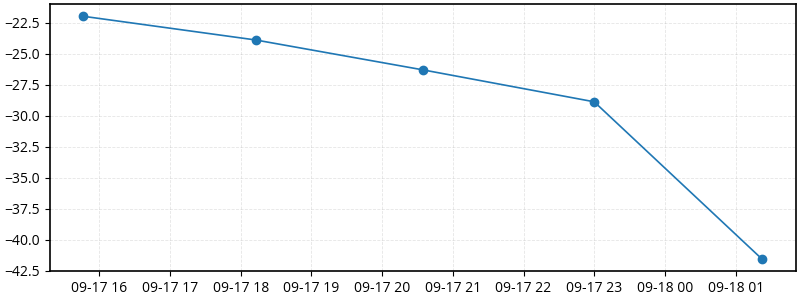

In [46]:
plt.close()
plt.figure(figsize=(8,3), constrained_layout=True)


plt.plot(Lagcur.time, (theta_wave-theta_tau)*180/pi, 'o-');
# plt.plot(Lagcur.time, theta_tau*180/pi, 'o-');
# plt.plot(Lagcur.time, theta_Lshr*180/pi, 'o-');
# plt.plot(Lagcur.time, (theta_Ltau+theta_tau)*180/pi, 'o-');
# plt.plot(dftb.time, np.arctan2(tmpy, tmpx)*180/pi, 's-');

# plt.plot(Lagcur.time, Lagcur.theta_wave/pi*180);

/home/zhihua/miniconda3/envs/scaOSBL/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  # This is added back by InteractiveShellApp.init_path()


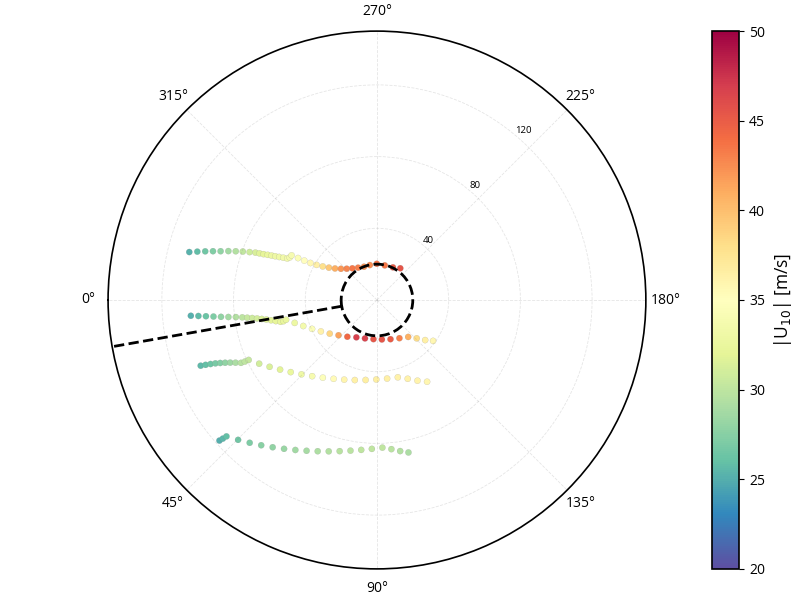

In [20]:
plt.close()
fig = plt.figure(figsize=(8,6), constrained_layout=True)

ax = fig.add_subplot(projection='polar')
ax.plot([10/180*pi, 10/180*pi], [20, 200], c='k', lw=2, ls='--')
ax.plot(np.linspace(0,2*pi), np.ones(50)*20, c='k', lw=2, ls='--')
sc = ax.scatter(fwind60.frdir/180*pi, fwind60.fdist, c=fwind60.U10, s=20, vmin=20, vmax=50, cmap='Spectral_r', edgecolors='gray', lw=0.1)
ax.scatter(fwind61.frdir/180*pi, fwind61.fdist, c=fwind61.U10, s=20, vmin=20, vmax=50, cmap='Spectral_r', edgecolors='gray', lw=0.1)
ax.scatter(fwind62.frdir/180*pi, fwind62.fdist, c=fwind62.U10, s=20, vmin=20, vmax=50, cmap='Spectral_r', edgecolors='gray', lw=0.1)
ax.scatter(fwind64.frdir/180*pi, fwind64.fdist, c=fwind64.U10, s=20, vmin=20, vmax=50, cmap='Spectral_r', edgecolors='gray', lw=0.1)
cbar = plt.colorbar(sc, label=r'|U$_{10}$| [m/s]')
ax.set_theta_zero_location('W')
ax.set_rmax(150)
ax.set_rgrids([40, 80, 120])
ax.set_yticklabels([40, 80, 120], fontsize=7)
ax.set_rlabel_position(230);
# plt.savefig(outfig_dir + 'float_pos_storm_ref.png');

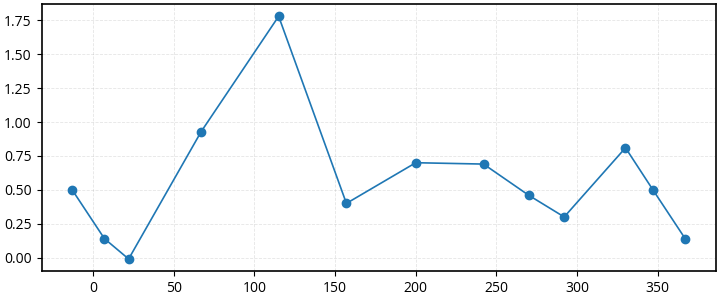

In [133]:
# theta = np.linspace(0,2*pi,300)/pi*180
# r = np.linspace(0,300,300)
# Theta, R = np.meshgrid(theta,r)
# chi = get_fetch(Theta, R)

theta_grid = np.array([-13, 7, 22, 67, 115, 157, 200, 242, 270, 292, 330, 347, 367])
A_grid = np.array([100, 94.72, 108.79, 77.47, -33.58, 37.75, 43.45, 134.73, 107.65, 149.25, 109.42, 100, 94.72])
alpha_grid = np.array([0.5, 0.14, -0.01, 0.93, 1.78, 0.4, 0.7, 0.69, 0.46, 0.3, 0.81, 0.5, 0.14])

plt.close()
fig = plt.figure(figsize=(7.2,3), constrained_layout=True)

# CS = plt.contour(-R*np.cos(Theta/180*pi), -R*np.sin(Theta/180*pi), chi, np.arange(60,240,20));
# ax.clabel(CS, CS.levels, inline=True, fontsize=6);

plt.plot(theta_grid, alpha_grid, 'o-');

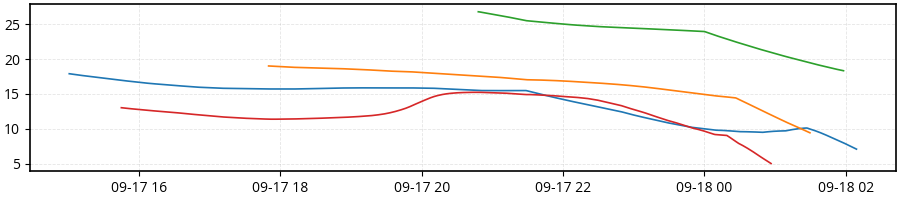

In [16]:
plt.close()
fig = plt.figure(figsize=(9,2), constrained_layout=True)

# plt.plot(trk_lon.time, trk_lon)
# plt.axhline(10, ls='--', c='r')
# plt.plot(fwind64.time, fwind64.frdir);

plt.plot(fwind60.time, fwind60.ewd/1e3);
plt.plot(fwind61.time, fwind61.ewd/1e3);
plt.plot(fwind62.time, fwind62.ewd/1e3);
plt.plot(fwind64.time, fwind64.ewd/1e3);

# plt.plot(fwind60.time, fwind60.taum);
# plt.plot(fwind62.time, fwind62.taum);
# plt.plot(fwind62.time, fwind62.taum);
# plt.plot(fwind64.time, fwind64.taum);
# plt.plot(fwind64.time, fwind64.taum_GFDL);

# plt.plot(fwind64.time, fwind64.ewd/1e3, '.');
# plt.plot(fwind64.time[ifl], fwind.U10[ifl], '.');
# plt.plot(fwind.time, fdis);

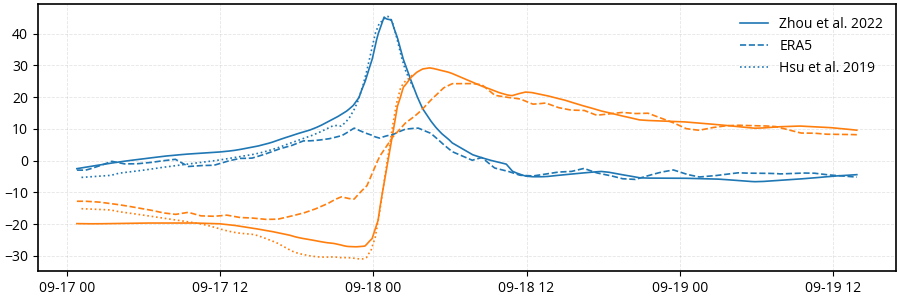

In [21]:
plt.close()
plt.figure(figsize=(9,3), constrained_layout=True)

# plt.plot(tmp.time, np.sqrt(tmp.u**2 + tmp.v**2));
plt.plot(fwinduri.time, fwinduri.u);
plt.plot(fwinduri.time, fwinduri.v, label='_nolegend_');
plt.gca().set_prop_cycle(None)
plt.plot(fmet.time, fmet.u10, '--');
plt.plot(fmet.time, fmet.v10, '--', label='_nolegend_');
plt.gca().set_prop_cycle(None)
plt.plot(fwind.time, fwind.u10, ':', ms=1, mew=0.3);
plt.plot(fwind.time, fwind.v10, ':', ms=1, mew=0.3, label='_nolegend_');

plt.legend(['Zhou et al. 2022', 'ERA5', 'Hsu et al. 2019'], fontsize=10, frameon=False);
# plt.savefig(outfig_dir + 'fanapi64_wind_compare.png');

# plt.contourf(era5.lon, era5.lat, era5.sp.sel(time='2010-09-17 06:30:00'))
# plt.plot(xr.DataArray(data=ep['lonnav'], dims=['time'], coords={'time': pytime}).interpolate_na('time', fill_value='extrapolate'),
#          xr.DataArray(data=ep['latnav'], dims=['time'], coords={'time': pytime}).interpolate_na('time', fill_value='extrapolate'),
#          '.-r', ms=2)
# plt.plot(ep['lonnav'], ep['latnav'], 'ok', ms=5, mew=0.3);
# plt.xlim(125, 127)
# plt.ylim(22.5, 24);

### Load Fanapi best track data

In [16]:
ds = xr.open_dataset(hurricane_met_dir+'IBTrACS.WP.v04r00.nc').load()
ds.close()
var_bstr = [var for var in ds.data_vars if ds[var].dtype.kind == 'S']
# var_float = [var for var in ds.data_vars if ds[var].dtype.kind == 'f']

/Users/zhihua/miniconda3/envs/scaOSBL/lib/python3.8/site-packages/xarray/coding/times.py:242: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/zhihua/miniconda3/envs/scaOSBL/lib/python3.8/site-packages/xarray/coding/times.py:242: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [10]:
for var in var_bstr:
    ds[var] = ds[var].astype('U')#ds[var].str.decode('UTF-8')

In [11]:
fanapi = ds.where(ds.name=='FANAPI', drop=True).transpose('date_time', 'quadrant', 'storm')
fanapi = fanapi.where(fanapi != '') # replace empty string with NaN
fanapi = fanapi.dropna('date_time', how='all') # drop null times
empty_vars = [var for var in fanapi.data_vars if fanapi[var].notnull().sum()==0]
fanapi = fanapi.drop_vars(empty_vars) # drop empty variables
fanapi['time'] = fanapi.time.squeeze()
fanapi  = fanapi.set_index(date_time='time')

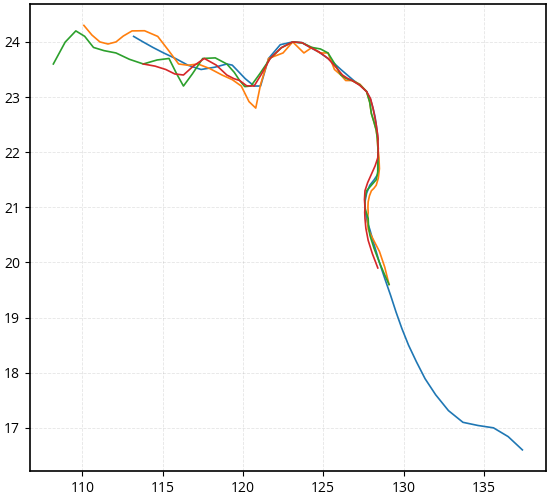

In [6]:
plt.close()
plt.figure(figsize=(5.5,5), constrained_layout=True)

plt.plot(fanapi.usa_lon, fanapi.usa_lat);
plt.plot(fanapi.tokyo_lon, fanapi.tokyo_lat);
plt.plot(fanapi.cma_lon, fanapi.cma_lat);
plt.plot(fanapi.hko_lon, fanapi.hko_lat);

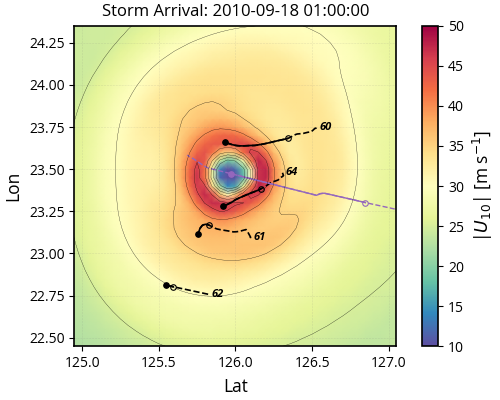

In [27]:
plt.close()
plt.figure(figsize=(5,4), constrained_layout=True)

time0 = pd.Timestamp('2010-09-18 01:00:00')

plt.text(env60.lon[0]+0.02, env60.lat[0], '60', size=8, weight='bold', style='italic', va='center')
plt.text(env61.lon[0]+0.02, env61.lat[0], '61', size=8, weight='bold', style='italic', va='center')
plt.text(env62.lon[0]+0.02, env62.lat[0], '62', size=8, weight='bold', style='italic', va='center')
plt.text(env64.lon[0]+0.02, env64.lat[0], '64', size=8, weight='bold', style='italic', va='center')
plt.plot(env60.lon.sel(time=slice(None,time0)),
         env60.lat.sel(time=slice(None,time0)), color='k', ls='--')
plt.plot(env61.lon.sel(time=slice(None,time0)),
         env61.lat.sel(time=slice(None,time0)), color='k', ls='--')
plt.plot(env62.lon.sel(time=slice(None,time0)),
         env62.lat.sel(time=slice(None,time0)), color='k', ls='--')
plt.plot(env64.lon.sel(time=slice(None,time0)),
         env64.lat.sel(time=slice(None,time0)), color='k', ls='--')

plt.plot(fwind60.lon[0], fwind60.lat[0], 'ok', mfc='none', ms=4, mew=0.8)
plt.plot(fwind61.lon[0], fwind61.lat[0], 'ok', mfc='none', ms=4, mew=0.8)
plt.plot(fwind62.lon[0], fwind62.lat[0], 'ok', mfc='none', ms=4, mew=0.8)
plt.plot(fwind64.lon[0], fwind64.lat[0], 'ok', mfc='none', ms=4, mew=0.8)

plt.plot(fwind60.lon.sel(time=time0, method='nearest'), fwind60.lat.sel(time=time0, method='nearest'), 'ok', ms=4, mew=0.8)
plt.plot(fwind61.lon.sel(time=time0, method='nearest'), fwind61.lat.sel(time=time0, method='nearest'), 'ok', ms=4, mew=0.8)
plt.plot(fwind62.lon.sel(time=time0, method='nearest'), fwind62.lat.sel(time=time0, method='nearest'), 'ok', ms=4, mew=0.8)
plt.plot(fwind64.lon.sel(time=time0, method='nearest'), fwind64.lat.sel(time=time0, method='nearest'), 'ok', ms=4, mew=0.8)

plt.plot(env60.lon.sel(time=slice(fwind60.time[0], time0)), 
         env60.lat.sel(time=slice(fwind60.time[0], time0)), color='k')
plt.plot(env61.lon.sel(time=slice(fwind61.time[0], time0)), 
         env61.lat.sel(time=slice(fwind61.time[0], time0)), color='k')
plt.plot(env62.lon.sel(time=slice(fwind62.time[0], time0)), 
         env62.lat.sel(time=slice(fwind62.time[0], time0)), color='k')
plt.plot(env64.lon.sel(time=slice(fwind64.time[0], time0)), 
         env64.lat.sel(time=slice(fwind64.time[0], time0)), color='k')

plt.plot(fwind61.trk_lon[0], fwind61.trk_lat[0], 'o', color='C4', mfc='none', ms=4, mew=0.8)
plt.plot(fwind64.trk_lon.sel(time=time0, method='nearest'), fwind64.trk_lat.sel(time=time0, method='nearest'), 'o', color='C4', ms=4, mew=0.8)
plt.plot(Fanapi.trk_lon, Fanapi.trk_lat, color='C4', lw=1, ls='--')
plt.plot(fwind61.trk_lon.sel(time=slice(None, time0)), 
         fwind61.trk_lat.sel(time=slice(None, time0)), color='C4', lw=1)

# plt.plot(fwind.trk_lon[i], fwind.trk_lat[i], 'p', c='C4', ms=4, mew=0.8)
# plt.plot(fanapi.usa_lon, fanapi.usa_lat, 'o-', ms=2, color='r', mfc='none', lw=0.5, mew=1)
# plt.plot(fanapi.tokyo_lon, fanapi.tokyo_lat, 'o-', ms=2, color='C4', mfc='none', lw=0.5, mew=1)
# plt.plot(fanapi.cma_lon, fanapi.cma_lat, 'o-', ms=2, color='C4', mfc='none', lw=0.5, mew=1)
# plt.plot(fanapi.hko_lon,#.sel(date_time=slice('2010-09-17 18','2010-09-18 12')),
#          fanapi.hko_lat,#.sel(date_time=slice('2010-09-17 18','2010-09-18 12')), 
#          ms=2, color='C4', lw=0.5, mew=1, ls=':')

plt.pcolormesh(Fanapi.lon, Fanapi.lat, Fanapi.U10.sel(time=time0, method='nearest'),
               cmap='Spectral_r', shading='gouraud', vmin=10, vmax=50)
plt.colorbar(label=r'|$U_{10}$| [m s$^{-1}$]')
plt.contour(Fanapi.lon, Fanapi.lat, Fanapi.U10.sel(time=time0, method='nearest'),
            np.arange(20,60,5), colors='k', linewidths=0.2)
plt.title(f'Storm Arrival: {time0}', fontsize=12)
plt.grid(lw=0.4)
plt.xlim(124.95, 127.05)
plt.ylim(22.45, 24.35);
plt.ylabel('Lon')
plt.xlabel('Lat');

plt.savefig(outfig_dir + 'Fanapi_map.png', dpi=600);

In [ ]:
plt.close()
plt.figure(figsize=(4,3), constrained_layout=True)

plt.pcolonp.arange(20,60,5)rmesh(U10uri.lon, U10uri.lat, U10uri.U10.sel(time=np.datetime64('2010-09-17 21:30:00'), method='nearest'),
               cmap='Spectral_r', shading='gouraud')
plt.colorbar(label=r'|U$_{10}$| [m/s]')
plt.clim(10, 50)
plt.contour(U10uri.lon, U10uri.lat, U10uri.U10.sel(time=np.datetime64('2010-09-17 21:30:00'), method='nearest'),
            np.arange(20,60,5), colors='k', linewidths=0.2)
plt.plot(trk.lon, trk.lat, 'm')
plt.plot(Hsu19['trk_lon'], Hsu19['trk_lat'], 'k')
# plt.title(fwind61.time[-1].values.astype('datetime64[s]'), fontsize=12);
plt.xlim(124.95, 127.05)
plt.ylim(22.45, 24.35);
